In [1]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

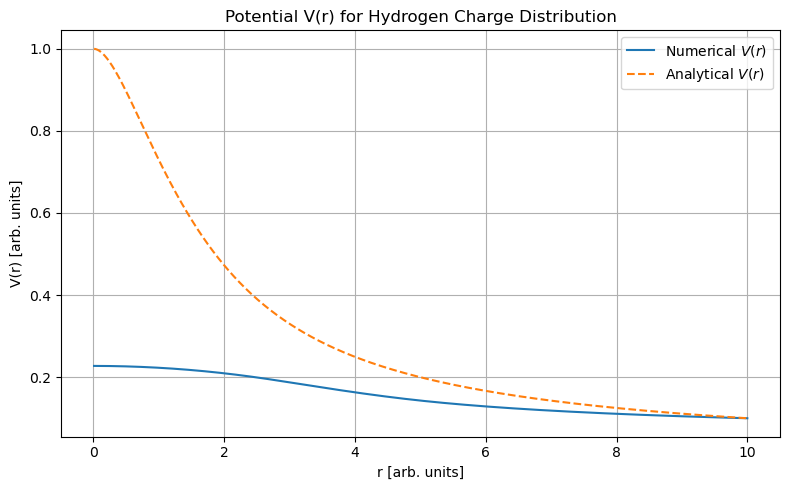

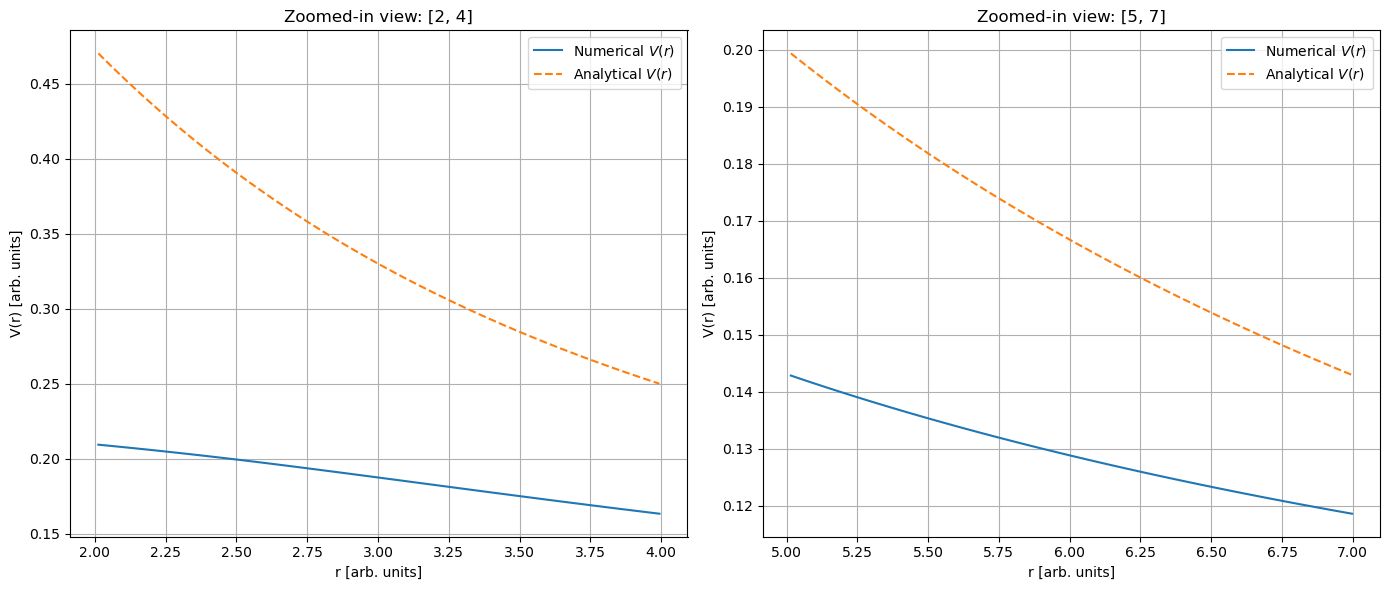

In [ ]:
# Parameters:
degree = 3  # order 4
a, b = 0.0, 10.0  
nknots = 5 # number of knots
#p = 2.0 ### hidrogeno
#xi = np.linspace(0, 1, nknots) ### hidrogeno
#knots = b * (xi**p) ### hidrogeno
knots = np.linspace(a, b, nknots) # physical points
augmented_knots = np.concatenate((np.repeat(knots[0], degree), knots, np.repeat(knots[-1], degree)))
n_basis = len(augmented_knots) - degree - 1
collocation_pts = knots

# Charge Distributions:

# Uniformly charged sphere 
R = 1.0
def rho_uniform_sphere(r, R=R):
    V = (4.0/3.0) * np.pi * R**3
    return np.where(r <= R, 1.0 / V, 0.0)

# Uniformly charged spherical shell
R1 = 0.5
R2 = 1.0
def rho_shell(r, R1=R1, R2=R2):
    V_shell = (4.0/3.0) * np.pi * (R2**3 - R1**3)
    return np.where((r >= R1) & (r <= R2), 1 / V_shell, 0.0)

# Hydrogen 
def rho_hydrogen(r):
    return (1.0 / np.pi) * np.exp(-2*r)


##################################################
density_type = 'hydrogen'  

if density_type == 'uniform':
    rho_func = lambda r: rho_uniform_sphere(r, R)
elif density_type == 'shell':
    rho_func = lambda r: rho_shell(r, R1, R2)
elif density_type == 'hydrogen':
    rho_func = lambda r: rho_hydrogen(r)
else:
    raise ValueError("You typed wrong")
#################################################

# Collocation matrix:
A = np.zeros((len(collocation_pts), n_basis))
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1  
    B_j = BSpline(augmented_knots, coeffs, degree)
    B_j_dd = B_j.derivative(nu=2)
    A[:, j] = B_j_dd(collocation_pts)


new_row = np.zeros(n_basis)
for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    new_row[j] = B_j(b)

A_bc = np.vstack([A, new_row])   

# RHS:
rhs = -collocation_pts * 4 * np.pi * rho_func(collocation_pts)
b_bc = np.append(rhs, 1.0)

# BC:s
A_reduced = A_bc[:, 1:]
c_reduced = np.linalg.solve(A_reduced, b_bc)
c_full = np.insert(c_reduced, 0, 0.0)  

# Start solving problem:
phi_spline = BSpline(augmented_knots, c_full, degree)
epsilon = 1e-2
r_vals = np.linspace(0.0+epsilon, b, 500)  
phi_vals = phi_spline(r_vals)
V_numerical = phi_vals / r_vals

# Analytical solutions:
def analytic_potential_uniform_sphere(r, R=R):
    V_anal = np.zeros_like(r)
    mask = r <= R
    V_anal[mask] = (1/R)*(3/2 - (r[mask]**2/2*R**2)) 
    V_anal[~mask] = 1.0 / r[~mask]
    return V_anal

def analytic_potential_shell(r, R1=R1, R2=R2):
    V_anal = np.zeros_like(r)
    # r < R1:
    mask1 = r < R1
    V_const = (3*(R2**2 - R1**2)) / (2*(R2**3 - R1**3))
    V_anal[mask1] = V_const
    # R1 <= r <= R2:
    mask2 = (r >= R1) & (r <= R2)
    r_in = r[mask2]
    Q_enc = (r_in**3 - R1**3) / (R2**3 - R1**3)
    term2 = (3*(R2**2 - r_in**2)) / (2*(R2**3 - R1**3))
    V_anal[mask2] = Q_enc / r_in + term2
    # r > R2:
    mask3 = r > R2
    V_anal[mask3] = 1.0 / r[mask3]
    return V_anal

def analytic_potential_hydrogen(r):
    return (1/r) - np.exp(-2*r)*((1/r) +1)

####################################################################    
if density_type == 'uniform':
    V_analytical = analytic_potential_uniform_sphere(r_vals, R)
elif density_type == 'shell':
    V_analytical = analytic_potential_shell(r_vals, R1, R2)
elif density_type == 'hydrogen':
    V_analytical = analytic_potential_hydrogen(r_vals)
else:
    raise ValueError("You typed wrong")

####################################################################

# Plot:
plt.figure(figsize=(8, 5))
plt.plot(r_vals, V_numerical, label='Numerical $V(r)$')
if density_type in ['uniform', 'shell', 'hydrogen']:
    plt.plot(r_vals, V_analytical, '--', label='Analytical $V(r)$')
plt.xlabel('r [arb. units]')
plt.ylabel('V(r) [arb. units]')
plt.title(f'Potential V(r) for {density_type.capitalize()} Charge Distribution')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

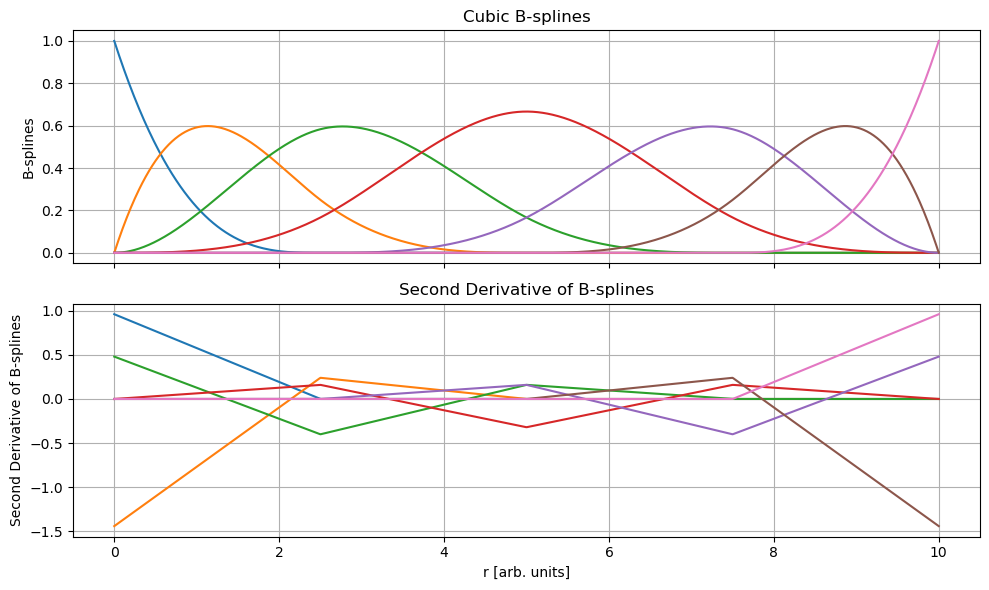

In [7]:
# Plot B-splines:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

r_fine = np.linspace(a, b, 1000)

for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    ax[0].plot(r_fine, B_j(r_fine))  
ax[0].set_ylabel('B-splines')
ax[0].set_title('Cubic B-splines')
ax[0].grid()

for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j_dd = BSpline(augmented_knots, coeffs, degree).derivative(nu=2)
    ax[1].plot(r_fine, B_j_dd(r_fine))
ax[1].set_ylabel("Second Derivative of B-splines")
ax[1].set_xlabel("r [arb. units]")
ax[1].set_title('Second Derivative of B-splines')
ax[1].grid()


plt.tight_layout()
plt.show()